In [184]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests_cache
import yfinance as yf
import torch

%matplotlib inline
sns.set_theme()
device = torch.device("mps")

session = requests_cache.CachedSession("base-model-1.cache")
print(device)

mps


In [185]:
aapl = yf.Ticker("AAPL").history(period="10y", interval="1d")[["Close"]]
aapl.head()

,Close
Date,
2013-10-11 00:00:00-04:00,15.360726
2013-10-14 00:00:00-04:00,15.461403
2013-10-15 00:00:00-04:00,15.543694
2013-10-16 00:00:00-04:00,15.619443
2013-10-17 00:00:00-04:00,15.725107


<Axes: xlabel='Date', ylabel='Close'>

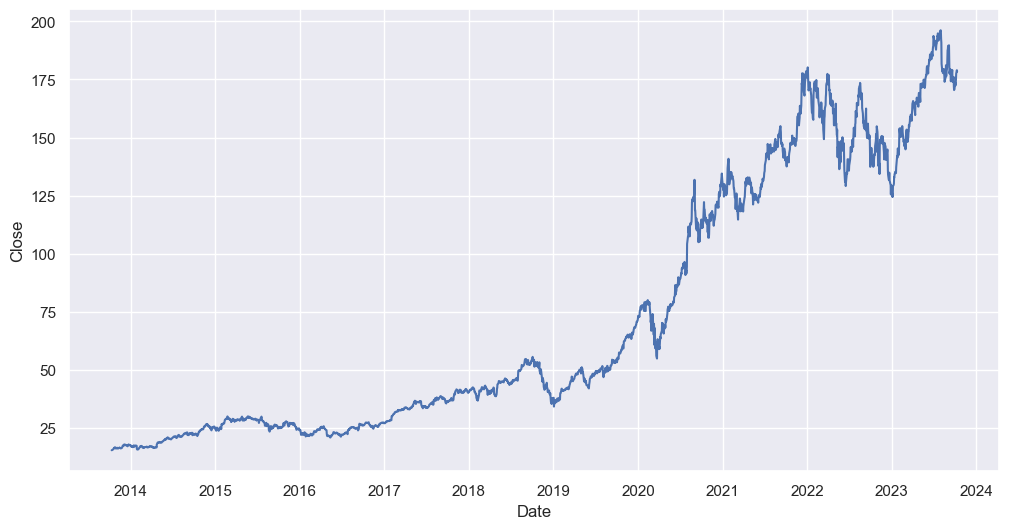

In [186]:
import warnings
warnings.filterwarnings("ignore")

fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=aapl, x=aapl.index, y="Close", ax=ax)

In [187]:
aapl

,Close
Date,
2013-10-11 00:00:00-04:00,15.360726
2013-10-14 00:00:00-04:00,15.461403
2013-10-15 00:00:00-04:00,15.543694
2013-10-16 00:00:00-04:00,15.619443
2013-10-17 00:00:00-04:00,15.725107
...,...
2023-10-04 00:00:00-04:00,173.660004
2023-10-05 00:00:00-04:00,174.910004
2023-10-06 00:00:00-04:00,177.490005


In [188]:
from sklearn.preprocessing import MinMaxScaler
price = aapl[['Close']]
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

In [189]:
price

,Close
Date,
2013-10-11 00:00:00-04:00,-1.000000
2013-10-14 00:00:00-04:00,-0.998886
2013-10-15 00:00:00-04:00,-0.997976
2013-10-16 00:00:00-04:00,-0.997138
2013-10-17 00:00:00-04:00,-0.995970
...,...
2023-10-04 00:00:00-04:00,0.750862
2023-10-05 00:00:00-04:00,0.764688
2023-10-06 00:00:00-04:00,0.793224


In [190]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]
lookback = 2 # choose sequence length. Given n-1 days, predict the nth day's close price
X_train, y_train, X_test, y_test = split_data(price, lookback)

In [191]:
import torch.nn as nn

X_train = torch.from_numpy(X_train).type(torch.Tensor).to(device)
X_test = torch.from_numpy(X_test).type(torch.Tensor).to(device)
y_train = torch.from_numpy(y_train).type(torch.Tensor).to(device)
y_test = torch.from_numpy(y_test).type(torch.Tensor).to(device)

In [192]:
print(f"X_train.shape = {X_train.shape}")
print(f"y_train.shape = {y_train.shape}")
print(f"X_test.shape = {X_test.shape}")
print(f"y_test.shape = {y_test.shape}")

X_train.shape = torch.Size([2011, 1, 1])
y_train.shape = torch.Size([2011, 1])
X_test.shape = torch.Size([503, 1, 1])
y_test.shape = torch.Size([503, 1])


In [193]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1

In [194]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device).requires_grad_()
        out, (_, _) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [195]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model = model.to(device)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [196]:
print(model)

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [197]:
def train(model: nn.Module, X_train: torch.Tensor, y_train: torch.Tensor, loss_fn, optimizer, should_print):
    model.train()
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if should_print:
        print(f"Train loss: {loss.item()}")
    return loss.item()

def test(model: nn.Module, X_test: torch.Tensor, y_test: torch.Tensor, loss_fn, should_print):
    model.eval()
    y_pred = model(X_test)
    loss = loss_fn(y_pred, y_test)

    if should_print:
        print(f"Test loss: {loss.item()}")
    return loss.item()

In [198]:
import time
from tqdm.notebook import trange

num_epochs = 100

train_hist = np.zeros(num_epochs)
test_hist = np.zeros(num_epochs)

start_time = time.time()
for t in trange(num_epochs):
    should_print = lambda t: False
    if should_print(t):
        print(f"Epoch {t+1} of {num_epochs}")
    train_hist[t] = train(model, X_train, y_train, criterion, optimizer, should_print=should_print(t))
    test_hist[t] = test(model, X_test, y_test, criterion, should_print=should_print(t))
    
training_time = time.time() - start_time
print("Training time: {}".format(training_time))

  0%|          | 0/100 [00:00<?, ?it/s]

Training time: 1.5315911769866943


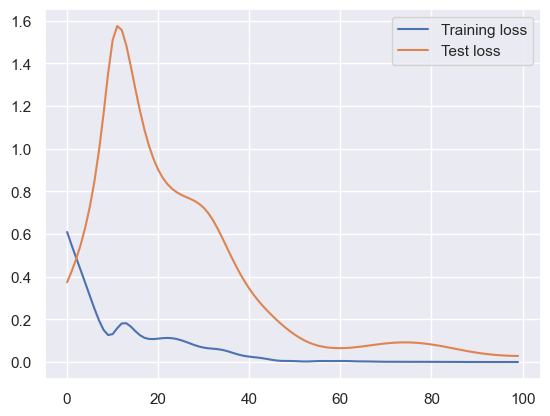

In [199]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.legend()
plt.show()

In [200]:
import math
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(X_test)

y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())

# calculate root mean squared error
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 15.33 RMSE


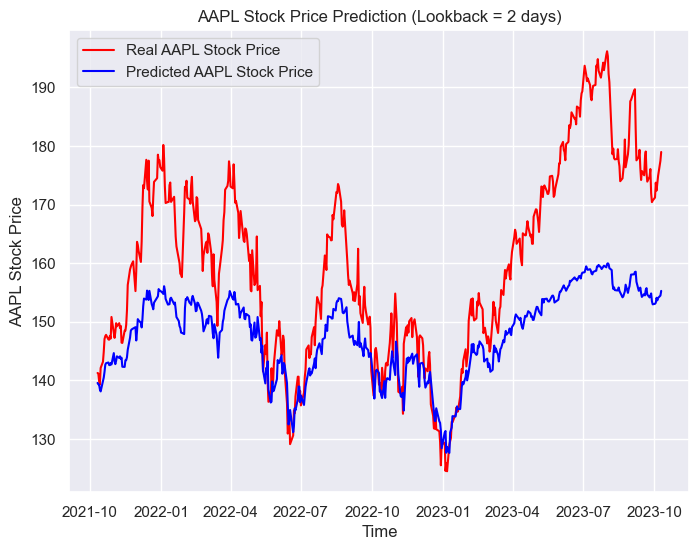

In [201]:
# Visualising the results
figure, axes = plt.subplots(figsize=(8, 6))
axes.xaxis_date()

axes.plot(aapl[len(aapl)-len(y_test):].index, y_test, color = 'red', label = 'Real AAPL Stock Price')
axes.plot(aapl[len(aapl)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted AAPL Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title(f'AAPL Stock Price Prediction (Lookback = {lookback} days)')
plt.xlabel('Time')
plt.ylabel('AAPL Stock Price')
plt.legend()
# plt.savefig('aapl_pred.png')
plt.show()

In [203]:
len(aapl), len(y_test)

(2516, 503)